## BigClam

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from random import random
import copy

In [2]:
# community class definition
class community:
    def __init__(self, member, prob):
        self.member = member
        self.prob = prob

In [3]:
# AGM 用于生成网络的一种模型
def AGM(nodes, communities):
    # create an empty graph
    G = nx.Graph()
    # add nodes to this graph
    G.add_nodes_from(nodes)
    
    # generate links within comminities
    for c in communities:
        for nodePairs in combinations(c.member, 2):
            if random() <= c.prob:
                G.add_edge(nodePairs[0], nodePairs[1])
    return G

In [22]:
# 根据BigClam中的公式计算出的一个社区能够包含两个点nodes的概率来画边
def graphFromCMSMatrix(M):
    G = nx.Graph()
    G.add_nodes_from(range(np.shape(M)[0]))
    
    for nodePairs in combinations(G.nodes(), 2):
        u, v = nodePairs
        if random() <= 1 - np.exp(-1*M[u, :]*M[v, :].transpose()):
            G.add_edge(u, v)
    return G

In [23]:
M = np.matrix('0 1.2 0 0.2; 0.5 0 0 0.8; 1 1.8 1 0')
M

matrix([[0. , 1.2, 0. , 0.2],
        [0.5, 0. , 0. , 0.8],
        [1. , 1.8, 1. , 0. ]])

In [24]:
np.shape(M)

(3, 4)

In [66]:
G = graphFromCMSMatrix(M)
G

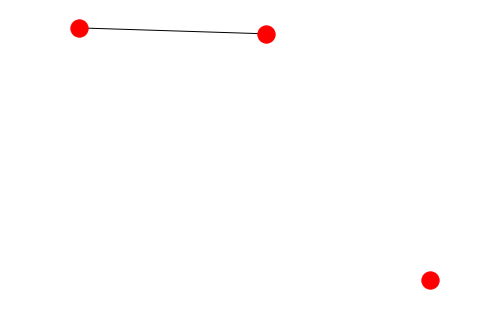

In [67]:
nx.draw(G)

In [80]:
# task:给定一个网络G(V,E)，如何拟合一个矩阵F使得生成的网络与给定网络最像
# realization of BigClam algorithm - version 1
# G = graph

def bigClam(G, numCommunities, maxIter=999, stepSize=0.01):
    # initialize a all-one matrix （主要是维度确认）
    F = np.matrix(np.ones((len(G.nodes()), numCommunities)))
    for i in range(np.shape(F)[0]):  # traverse rows -- one entity
        for j in range(np.shape(F)[1]):  # traverse columns -- community
            # initialize a random matrix
            F[i, j] = random()
    # start iterating
    for i in range(maxIter):
        # iterative over the rows of the matrix
        Fp = F.copy()
        # traverse rows one by one
        for row in range(np.shape(F)[0]):  # row_num
            # calculate the gradient
            gradient = np.matrix(np.zeros((1, numCommunities)))
            u = F[row, :]
            ##############################
            # update the row Fu - gradient
            for col in G.neighbors(row):  # traverse neighbors belonging to a row-注意：此处的一行row就是一个个体！！row=个体
                v = F[col, :]
                gradient = gradient + v*float(np.exp(-1*u*v.transpose())/
                                             (1-np.exp(-1*u*v.transpose())))
            for col in [i for i in range(np.shape(F)[0]) if i != row and i 
                       not in G.neighbors(row)]:
                v = F[col, :]
                gradient = gradient - v
            F[row, :] = F[row, :] + stepSize * gradient
            ###############################
            for i in range(numCommunities):  # make sure this matrix is NM - Nonnegative Matrix
                if F[row, i] < 0:
                    F[row, i] = 0
        # condition of stopping iteration
#         if sum(sum(np.multiply(F-Fp, F-Fp)))**0.5 <= 0.0001:
        if sum(sum(np.multiply(np.array(F-Fp), np.array(F-Fp))))**0.5 <= 0.01:
            print('current times of iteration: ', i)
            break
    return F


In [81]:
# construct a network with 3 communities and 24 nodes
nodes = range(24)
communities = [community(range(12), 0.8),
              community(range(6, 17), 0.8),
              community(list(range(8, 12)) + list(range(17, 24)), 0.8)]
# random.seed(123)

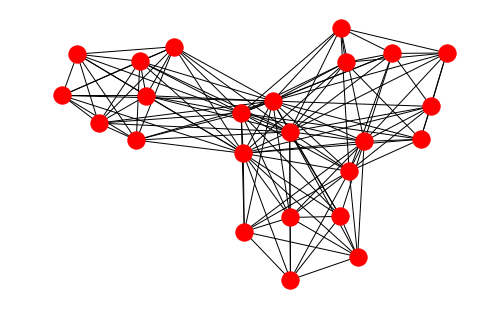

In [82]:
G = AGM(nodes, communities)
nx.draw(G)

In [83]:
F = bigClam(G, 3)

current times of iteration:  2


In [84]:
F

matrix([[1.1761142 , 0.        , 0.        ],
        [1.1783636 , 0.        , 0.        ],
        [0.95831066, 0.        , 0.        ],
        [1.018051  , 0.        , 0.        ],
        [1.09710226, 0.        , 0.        ],
        [1.62818943, 0.        , 0.        ],
        [1.0555873 , 0.        , 1.36807597],
        [1.68740472, 0.        , 1.39205103],
        [1.63408376, 0.84811271, 1.28159382],
        [2.71048123, 1.32803342, 0.68188321],
        [1.03837783, 1.34899899, 0.73874379],
        [0.57164332, 1.20423376, 2.28865991],
        [0.        , 0.        , 2.74602587],
        [0.        , 0.        , 1.22638068],
        [0.        , 0.        , 1.00511599],
        [0.        , 0.        , 1.48883218],
        [0.        , 0.        , 1.24293921],
        [0.        , 1.67371601, 0.        ],
        [0.        , 1.56383333, 0.        ],
        [0.        , 1.18905832, 0.        ],
        [0.        , 2.65064984, 0.        ],
        [0.        , 1.55798714, 0

In [85]:
# task:给定一个网络G(V,E)，如何拟合一个矩阵F使得生成的网络与给定网络最像
# realization of BigClam algorithm - version 2 - cache sum(Fv) to speed up
# G = graph

def bigClam2(G, numCommunities, maxIter=999, stepSize=0.01):
    # initialize a random matrix
    F = np.matrix(np.ones((len(G.nodes()), numCommunities)))
    for i in range(np.shape(F)[0]):
        for j in range(np.shape(F)[1]):
            F[i, j] = random()
            
    # start iterating
    for i in range(maxIter):
        # iterative over the rows of the matrix
        Fp = F.copy()
        colSums = np.sum(F, axis = 0)
        for row in range(np.shape(F)[0]):
            # calculate the gradient
            u = F[row, :]
            # 初始化两个矩阵
            gradient = np.matrix(np.zeros((1, numCommunities)))
            neighborSums = np.matrix(np.zeros((1, numCommunities)))
            for col in G.neighbors(row):
                v = F[col, :]
                gradient = gradient + v*float(np.exp(-1*u*v.transpose())/
                                             (1-np.exp(-1*u*v.transpose())))
                neighborSums = neighborSums + v
            gradient = gradient - (colSums - u - neighborSums)
            F[row, :] = F[row, :] + stepSize * gradient
            for i in range(numCommunities):
                if F[row, i] < 0:
                    F[row, i] = 0
        if sum(sum(np.multiply(np.array(F-Fp), np.array(F-Fp))))**0.5 <= 0.01:
            print('current times of iteration: ', i)
            break 
    return F
        

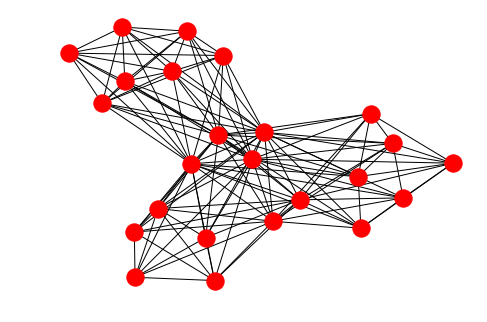

In [86]:
nx.draw(G)

### Attention: 
Every time we use nx.draw(G), we will get different network. Therefore, to get 'same' results through bigClam and bigClam2, we'd better calculate bigClam(G, 3) and bigClam2(G, 3) at the same time.

In [87]:
F1 = bigClam(G, 3)
F2 = bigClam2(G, 3)

current times of iteration:  2
current times of iteration:  2


In [88]:
F1

matrix([[0.        , 0.        , 1.19769641],
        [0.        , 0.        , 1.19102985],
        [0.        , 0.        , 0.95773839],
        [0.        , 0.        , 1.03567683],
        [0.        , 0.        , 1.10010384],
        [0.        , 0.        , 1.66485231],
        [0.        , 1.36779724, 1.03248861],
        [0.        , 1.40169273, 1.6293112 ],
        [0.84304586, 1.32408984, 1.62307428],
        [1.31613397, 0.69292939, 2.56246142],
        [1.33694619, 0.75275192, 1.02098533],
        [1.18299108, 2.53533363, 0.55855643],
        [0.        , 2.77063569, 0.        ],
        [0.        , 1.22195083, 0.        ],
        [0.        , 0.99047707, 0.        ],
        [0.        , 1.46645436, 0.        ],
        [0.        , 1.22109543, 0.        ],
        [1.69904804, 0.        , 0.        ],
        [1.56050495, 0.        , 0.        ],
        [1.19891245, 0.        , 0.        ],
        [2.61523058, 0.        , 0.        ],
        [1.56647241, 0.        , 0

In [89]:
F2

matrix([[0.        , 0.        , 1.12026876],
        [0.        , 0.        , 1.16380764],
        [0.        , 0.        , 0.93268177],
        [0.        , 0.        , 0.96480977],
        [0.        , 0.        , 1.07683634],
        [0.        , 0.        , 1.61037676],
        [0.        , 1.22558564, 1.14189531],
        [0.        , 1.25461907, 1.90323971],
        [0.84313439, 1.31483805, 1.75255868],
        [1.31974711, 0.6459882 , 2.84967301],
        [1.33528397, 0.68891609, 1.09794585],
        [1.23210331, 2.34687332, 0.58976748],
        [0.        , 2.77835316, 0.        ],
        [0.        , 1.29359695, 0.        ],
        [0.        , 1.05602456, 0.        ],
        [0.        , 1.56941939, 0.        ],
        [0.        , 1.22483345, 0.        ],
        [1.63984992, 0.        , 0.        ],
        [1.55427551, 0.        , 0.        ],
        [1.19389693, 0.        , 0.        ],
        [2.64117539, 0.        , 0.        ],
        [1.56770878, 0.        , 0

#### numpy test

In [39]:
np.ones(5)

array([1., 1., 1., 1., 1.])

In [40]:
np.ones((2,5))

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [23]:
c = np.matrix(np.ones((2,5)))
c

matrix([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [24]:
c.transpose()

matrix([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])

In [41]:
np.shape(c)

(2, 5)

In [51]:
[1,2 ] = random()

SyntaxError: can't assign to literal (<ipython-input-51-556595330dee>, line 1)

In [68]:
d = np.array(c)

In [69]:
d

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [110]:
e = np.ones((2,5))
e

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [111]:
e[1,3] = random()
e

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 0.87926958, 1.        ]])

In [113]:
f = np.sum(e, axis=0)
f

array([2.        , 2.        , 2.        , 1.87926958, 2.        ])

In [115]:
g = np.sum(e, axis=1)
g

array([5.        , 4.87926958])

In [73]:
range(4)

range(0, 4)

In [74]:
for i in range(4):
    print(i)

0
1
2
3


In [76]:
F1 = np.matrix(np.ones((2, 3)))
F1

matrix([[1., 1., 1.],
        [1., 1., 1.]])

In [77]:
F1[0]

matrix([[1., 1., 1.]])

In [78]:
F1[1]

matrix([[1., 1., 1.]])

In [79]:
F1[2]

IndexError: index 2 is out of bounds for axis 0 with size 2